In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import plotly.express as px
import geopandas as gpd
import matplotlib.patches as mpatches

### Setting Up Data and Some Measures

#### Import Stations, Define Haversine

In [21]:
stations = pd.read_csv('11.17.25_Bluebikes_Station_List.csv', skiprows=1)
print(stations.head())

# Define the given latitude and longitude (center point)
center_lat = stations['Lat'].mean()
center_lon = stations['Long'].mean()

# Function to calculate distance using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Calculate distance to the center for each row
stations['distance_to_center'] = haversine(stations['Lat'], stations['Long'], center_lat, center_lon)
stations['far_from_center'] = stations['distance_to_center'] > 4


   Number                               NAME        Lat       Long  \
0  C32083  Washington St at Walsh Playground  42.277195 -71.069556   
1  C32067       Washington St at Peters Park  42.343852 -71.067646   
2  C32084         Washington St at Fuller St  42.281986 -71.071479   
3  C32081       Washington St at Denton Terr  42.280728 -71.134238   
4  C32042        Washington St at Bowdoin St  42.299165 -71.073459   

  Seasonal Status Municipality  Total Docks  \
0  Winter Storage       Boston           19   
1  Winter Storage       Boston           19   
2      Year Round       Boston           15   
3  Winter Storage       Boston           19   
4  Winter Storage       Boston           15   

  Station ID (to match to historic system data)  
0                                           430  
1                                           412  
2                                           431  
3                                           427  
4                                           25

#### Import Trip Data

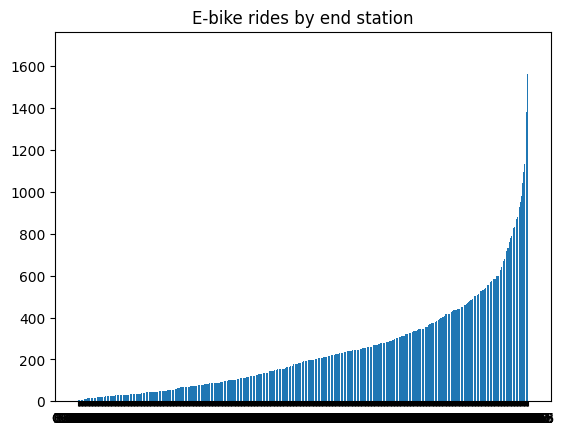

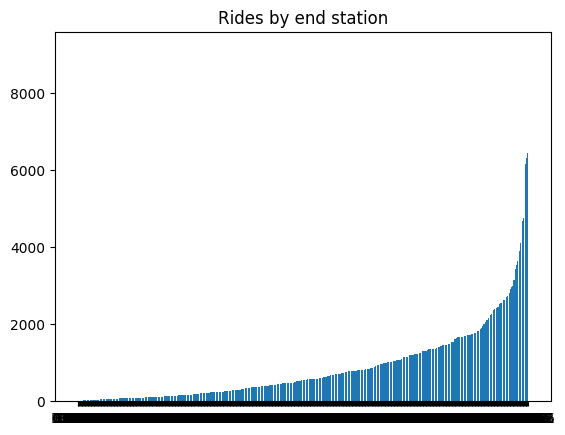

In [22]:
oct25trips = pd.read_csv('202510-bluebikes-tripdata.csv')
oct25started = oct25trips.groupby('end_station_id').describe()['start_lat']
oct25started = oct25started.sort_values(by='count')

ebikes = oct25trips[oct25trips['rideable_type'] == 'electric_bike']

ebikes_by_endpoint = ebikes.groupby('end_station_id').describe()['end_lat']
ebikes_by_endpoint = ebikes_by_endpoint.sort_values(by='count')

plt.bar(ebikes_by_endpoint.index, ebikes_by_endpoint['count'])
plt.title('E-bike rides by end station')
plt.show()

plt.bar(oct25started.index,oct25started['count'])
plt.title('Rides by end station')
plt.show()

#### Add to Stations: Count of All Bikes, Count of E-Bikes, E-Bike Trip Ratio

In [23]:

stations = stations.merge(
    oct25started[['count']],
    how='left',  # Use 'left' join to keep all rows in stations
    left_on='Number',  # Column in stations to join on
    right_on=oct25started.index  # Column in oct25started to join on
)


stations = stations.merge(
    ebikes_by_endpoint[['count']],
    how='left',  # Use 'left' join to keep all rows in stations
    left_on='Number',  # Column in stations to join on
    right_on=ebikes_by_endpoint.index  # Column in oct25started to join on
)

stations = stations.rename(columns = {'count_x': 'count_all_bikes', 'count_y': 'count_ebikes'} )

# Ensure the columns are Series, not DataFrames
stations['count_all_bikes'] = stations['count_all_bikes'].squeeze()
stations['count_ebikes'] = stations['count_ebikes'].squeeze()

stations['ratio_ebikes'] = stations['count_ebikes'] / stations['count_all_bikes'].replace(0, np.nan)


print(stations.head())

   Number                               NAME        Lat       Long  \
0  C32083  Washington St at Walsh Playground  42.277195 -71.069556   
1  C32067       Washington St at Peters Park  42.343852 -71.067646   
2  C32084         Washington St at Fuller St  42.281986 -71.071479   
3  C32081       Washington St at Denton Terr  42.280728 -71.134238   
4  C32042        Washington St at Bowdoin St  42.299165 -71.073459   

  Seasonal Status Municipality  Total Docks  \
0  Winter Storage       Boston           19   
1  Winter Storage       Boston           19   
2      Year Round       Boston           15   
3  Winter Storage       Boston           19   
4  Winter Storage       Boston           15   

  Station ID (to match to historic system data)  distance_to_center  \
0                                           430            9.334084   
1                                           412            2.392088   
2                                           431            8.783920   
3           

#### Count of Total Starts and Ends by Station

In [24]:
# Count of Total Starts and Ends by Station

ebikes_by_start = ebikes.groupby(['start_station_id']).size().reset_index(name='num_starts')
ebikes_by_start = ebikes_by_start.sort_values(by='num_starts', ascending=False)

ebikes_by_end = ebikes.groupby(['end_station_id']).size().reset_index(name='num_ends')
ebikes_by_end = ebikes_by_end.sort_values(by='num_ends', ascending=False)

station_lookup = stations.set_index('Number')['NAME']
ebikes_by_start['start_station_name'] = ebikes_by_start['start_station_id'].map(station_lookup)
ebikes_by_end['end_station_name'] = ebikes_by_end['end_station_id'].map(station_lookup)

ebikes_by_start

,start_station_id,num_starts,start_station_name
117,B32065,1674,Massachusetts Ave at Boylston St.
2,A32002,1558,Commonwealth Ave at Agganis Way
395,M32006,1388,MIT at Mass Ave / Amherst St
405,M32018,1380,Harvard Square at Mass Ave/ Dunster
398,M32011,1199,Central Square at Mass Ave / Essex St
...,...,...,...
224,C32100,5,Hyde Park Ave at Arlington St
335,E32014,5,Ross Playground
349,F32011,5,Carr Park
225,C32101,4,American Legion Hwy at Hyde Park Ave


#### Starts per Dock per Station

In [25]:
# Number of Departures per Dock per Station

docks_map = stations.set_index('Number')['Total Docks']

ebikes_by_start['starts_per_dock'] = ebikes_by_start['start_station_id'].map(docks_map)

ebikes_by_start['starts_per_dock'] = ebikes_by_start['num_starts'] / ebikes_by_start['starts_per_dock']

ebikes_by_start = ebikes_by_start[np.isfinite(ebikes_by_start['starts_per_dock'])]
ebikes_by_start.sort_values(by='starts_per_dock', ascending=False)

,start_station_id,num_starts,start_station_name,starts_per_dock
2,A32002,1558,Commonwealth Ave at Agganis Way,103.866667
405,M32018,1380,Harvard Square at Mass Ave/ Dunster,72.631579
117,B32065,1674,Massachusetts Ave at Boylston St.,69.750000
114,B32062,1037,Forsyth St at Huntington Ave,69.133333
398,M32011,1199,Central Square at Mass Ave / Essex St,63.105263
...,...,...,...,...
501,R32007,4,Revere Public Library,0.363636
88,B32024,6,Pilgrim Rd at Brookline Ave,0.315789
224,C32100,5,Hyde Park Ave at Arlington St,0.263158
335,E32014,5,Ross Playground,0.263158


#### Quantile Measures of Departures

In [26]:
ebikes_by_start['departure_percentile'] = (ebikes_by_start['num_starts'].rank(pct=True) * 100)  # stores the station's quantile for departures

departure_quantiles = ebikes_by_start['num_starts'].quantile([0.25, 0.5, 0.75])  # returns the 25th, 50th, and 75th quartiles
departure_quantiles

C:\Users\Julie\AppData\Local\Temp\ipykernel_7376\2335684913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebikes_by_start['departure_percentile'] = (ebikes_by_start['num_starts'].rank(pct=True) * 100)  # stores the station's quantile for departures


0.25     73.0
0.50    189.0
0.75    336.0
Name: num_starts, dtype: float64

#### Frequency of Each Unique Trip

In [27]:
# Frequency of Each Unique Route (station i to station j)

ebikes_by_trip = ebikes.groupby(['start_station_id','end_station_id']).size().reset_index(name='num_trips')
ebikes_by_trip = ebikes_by_trip.sort_values(by='num_trips', ascending=False)

station_lookup = stations.set_index('Number')['NAME']  # Set dictionary for map func to reference

ebikes_by_trip['start_station_name'] = ebikes_by_trip['start_station_id'].map(station_lookup)  # Names of start and end stations
ebikes_by_trip['end_station_name'] = ebikes_by_trip['end_station_id'].map(station_lookup)

ebikes_by_trip

,start_station_id,end_station_id,num_trips,start_station_name,end_station_name
340,A32002,B32060,136,Commonwealth Ave at Agganis Way,Commonwealth Ave at Granby St
12169,B32060,A32002,130,Commonwealth Ave at Granby St,Commonwealth Ave at Agganis Way
12744,B32063,B32062,107,St. Alphonsus St at Tremont St,Forsyth St at Huntington Ave
398,A32002,D32032,90,Commonwealth Ave at Agganis Way,Silber Way
8956,B32016,M32006,89,Beacon St at Massachusetts Ave,MIT at Mass Ave / Amherst St
...,...,...,...,...,...
53461,Z32998,M32063,1,Broadway at Kittie Knox Bike Path,Sennott Park Broadway at Norfolk Street
23123,D32006,M32037,1,Lewis Wharf at Atlantic Ave,Ames St at Main St
53459,Z32998,M32061,1,Broadway at Kittie Knox Bike Path,Mass Ave at Albany St
23122,D32006,M32034,1,Lewis Wharf at Atlantic Ave,EF - North Point Park


#### Plotting Time Distribution of Inbound and Outbound Trips for a Station

C:\Users\Julie\AppData\Local\Temp\ipykernel_7376\1575810713.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebikes['started_at'] = pd.to_datetime(ebikes['started_at'])
C:\Users\Julie\AppData\Local\Temp\ipykernel_7376\1575810713.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebikes['ended_at'] = pd.to_datetime(ebikes['ended_at'])


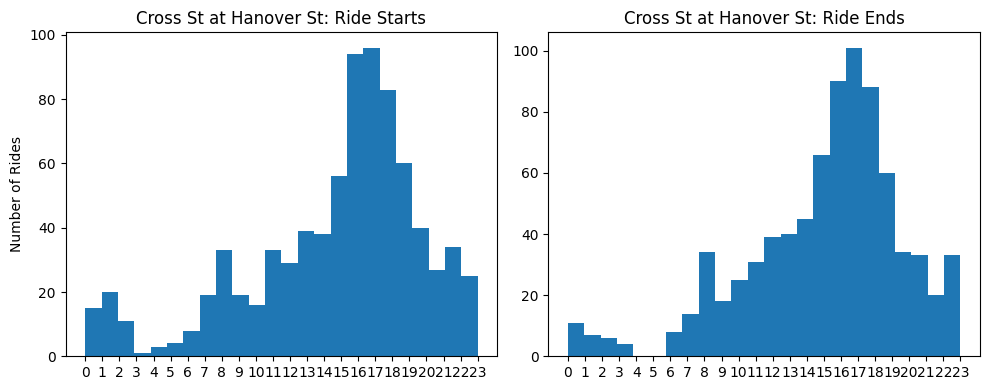

In [28]:
# Plotting Time Distribution of Inbound and Outbound Volume for a Station

fig, axs = plt.subplots(1, 2, figsize=(10,4))

# Ensure Date Time Type
ebikes['started_at'] = pd.to_datetime(ebikes['started_at'])
ebikes['ended_at'] = pd.to_datetime(ebikes['ended_at'])

# Change this to ID of station you want to look at
station_id = 'D32010'
station_name = station_lookup[station_id]

# Station Starts (Outbound)
ebikes_station_start = ebikes.loc[ebikes['start_station_id'] == station_id].copy()
ebikes_station_start['start_hour'] = ebikes_station_start['started_at'].dt.hour

axs[0].hist(ebikes_station_start['start_hour'], bins=24)
axs[0].set_title(f"{station_name}: Ride Starts")
axs[0].set_ylabel('Number of Rides')

# Station Ends (Inbound)
ebikes_station_end = ebikes.loc[ebikes['end_station_id'] == station_id].copy()
ebikes_station_end['end_hour'] = ebikes_station_end['ended_at'].dt.hour

axs[1].hist(ebikes_station_end['end_hour'], bins=24)
axs[1].set_title(f"{station_name}: Ride Ends")

# Formatting
for ax in axs.flat:
    ax.set_xticks(range(24))

plt.tight_layout()
plt.show()

### Maps with Folium

#### Map of Stations with Usage & E-Bike Ratios

In [29]:
from matplotlib.colors import to_hex
import branca.colormap as colm
# Create a folium map centered at the average latitude and longitude
station_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)
threshold_red = 0.3
cm = plt.get_cmap('cool')



# Create a colormap using branca that matches the matplotlib colormap
colormap = colm.LinearColormap(
    colors=[to_hex(plt.get_cmap('cool')(i)) for i in range(256)],
    vmin=stations['ratio_ebikes'].min(),
    vmax=stations['ratio_ebikes'].max(),
    caption='Ratio of E-Bikes'  # Add a caption for the color bar
)

# Add CircleMarkers for each station
for _, row in stations.iterrows():

    color = to_hex(cm(row['ratio_ebikes']))
    
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius= max( (row['count_ebikes']) // 70,3),  # Marker size
        color= color, #'blue' if row['ratio_ebikes'] > threshold_red else 'red',
        fill=True,
        fill_color= color, #'blue' if row['ratio_ebikes'] > threshold_red else 'red',
        fill_opacity=0.6,
        popup=f"Name: {row['NAME']}, e-bike count: {row['count_ebikes']}"  # Optional popup with station name
    ).add_to(station_map)
    
# Add the colormap to the map
colormap.add_to(station_map)

display(station_map)

#### Function to Get Map of Stations

In [48]:
#for _, row in stations.iterrows():    

def build_map(id_list):  #list = ['id1', 'id2', 'id3', ...]

    # Create a folium map centered at the average latitude and longitude
    station_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)
    threshold_red = 0.3
    cm = plt.get_cmap('cool')

    for id in id_list:
        row = stations.loc[stations['Number'] == id]

        folium.CircleMarker(
            location=[row['Lat'].iloc[0], row['Long'].iloc[0]],
            color= 'blue', 
            fill=True,
            fill_color= 'blue', 
            fill_opacity=0.6,
            popup=f"Name: {row['NAME']}, e-bike count: {row['count_ebikes']}"  # Optional popup with station name
        ).add_to(station_map)
    
    # Add the colormap to the map
    colormap.add_to(station_map)

    display(station_map)

### Max Min Distance

This fairness metric will determine which $k$ stations out of $n$ total stations to electrify such that we minimize the maximum of minimum distance from any station $x_i$ to an electrified station $x_j$: $$ \max_{i \in n} \left( \min_{k \in j} d(x_i, x_j) \right) $$

#### Open to set station coordinates and distance matrix (choose to include/exclude Salem)

##### Includes all $n$ stations in matrix

In [44]:
# Import to generate combinations of possible k stations
from itertools import combinations

# Set station coordinates
coordinates = stations.set_index('Number')[['Lat', 'Long']].to_dict('index')
station_ids = coordinates.keys()

# Precompute distance matrix
lat = stations['Lat'].values
lon = stations['Long'].values
coordinates = np.column_stack((lat, lon))

lat1 = coordinates[:, None, 0]
lat2 = coordinates[None, :, 0]
lon1 = coordinates[:, None, 1]
lon2 = coordinates[None, :, 1]
dist_matrix = haversine(lat1, lon1, lat2, lon2)

# Map station ID to index in matrix
id_to_idx = {station_id: idx for idx, station_id in enumerate(station_ids)}

##### Excludes Salem stations from matrix

In [42]:
# Set station coordinates
stations_filtered = stations[stations['Municipality'] != 'Salem'].copy()
coordinates = stations_filtered.set_index('Number')[['Lat', 'Long']].to_dict('index')
station_ids = coordinates.keys()

# Precompute Distance Matrix
lat = stations_filtered['Lat'].values
lon = stations_filtered['Long'].values
coordinates = np.column_stack((lat, lon))

lat1 = coordinates[:, None, 0]
lat2 = coordinates[None, :, 0]
lon1 = coordinates[:, None, 1]
lon2 = coordinates[None, :, 1]
dist_matrix = haversine(lat1, lon1, lat2, lon2)

# Map station ID to index in matrix
id_to_idx = {station_id: idx for idx, station_id in enumerate(station_ids)}

#### Max Min Function -- Input: stations list and $k$, Output: best $k$ stations and final distance

In [33]:
def maxmin_k_stations(bike_stations, k):                          # bike_stations = list of station IDs as strings ['id1','id2',...], k = number included in final rankings
    
    combos = combinations(bike_stations, k)

    final_min_max = 100000000000
    max_combo = []

    for combo in combos:
        combo_idx = [id_to_idx[ID] for ID in combo]        # Convert station IDs to indices in distance matrix
        min_dists = dist_matrix[:, combo_idx].min(axis=1)  # Get distance to nearest station in combo for all stations
        max_dist = min_dists.max()                         # Max distance from any station to nearest in combo
        
        if max_dist < final_min_max:
            final_min_max = max_dist
            max_combo = combo
    
    print("Max Distance:", final_min_max)
    print("--Stations List--")
    for i in range(len(max_combo)):
        station = stations.set_index('Number').loc[max_combo[i], 'NAME']
        print(station)

    return final_min_max, max_combo

### Metric: Charging Time Score

The goal of this metric is to determine which stations balance high daytime usage with low nighttime usage/longer low usage blocks to allow for adequate charging windows (i.e. if the busiest station in Boston has bikes leaving every 5 minutes throughout the day, will the charging actually be useful?)
$$N_i(t,\Delta) = \text{the number of departures from station } i \text{ in the time window } [t, t+\Delta)$$
where $\Delta$ is a time interval amount to bucket the data. Then, let $\tau$ be a threshold for the number of departures in the window considered to be efficient (consider using the nth percentile of the top m stations as the threshold?) Then, we can say that the total charging time available at station $i$ in the day is: $$C_i = \sum_t \mathbb{1} \{N_i(t,\Delta) \leq \tau\} \cdot \Delta$$ 
where the indicator function is equal to 1 if the number of departures in the window is below the threshold $\tau$.\

The least used stations have the highest values for $C_i$, so instead of using the total number of charging minutes, the code above produces a charging score that considers both available minutes for charging and total number of departures over the month with the measure $$\text{charging score} = \text{number of departures} \cdot \frac{\text{number of downtime 30min intervals}}{\text{total number of intervals}}$$
The charging score should be highest when both downtime and number of departures are high (should consider that significantly higher numbers of departures skew results)

#### Finding Quantiles -- measure which stations have more concentrated bike use by time distribution

In [34]:
ebikes['start_minutes'] = ebikes['started_at'].dt.hour * 60 + ebikes['started_at'].dt.minute

station_quantiles = ebikes.groupby('start_station_id')['start_minutes'].quantile([0.25, 0.75]).unstack()
station_quantiles = station_quantiles.rename(columns={0.25: 'q25', 0.75: 'q75'})

station_quantiles['quantile_difference'] = station_quantiles['q75'] - station_quantiles['q25']  # Difference between quantiles
station_quantiles = station_quantiles.sort_values(by='quantile_difference')

station_quantiles['station_name'] = station_quantiles.index.map(station_lookup)  # Adding station name
station_quantiles = station_quantiles[['station_name', 'q25', 'q75', 'quantile_difference']]  # Reorder columns

# Lower number -> more concentrated bike use
station_quantiles.head()

C:\Users\Julie\AppData\Local\Temp\ipykernel_7376\3503375447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebikes['start_minutes'] = ebikes['started_at'].dt.hour * 60 + ebikes['started_at'].dt.minute


,station_name,q25,q75,quantile_difference
start_station_id,,,,
F32011,Carr Park,403.00,407.00,4.0
E32014,Ross Playground,1029.00,1048.00,19.0
C32100,Hyde Park Ave at Arlington St,712.00,763.00,51.0
C32039,Park St at Norwell St,899.75,994.25,94.5
T32012,Salem MBTA - Lower Level,967.75,1085.25,117.5


#### Function to Compute the Downtime Fraction for delta, tau values

In [35]:
def compute_downtime_fraction(e_bikes, delta, tau, station_lookup):
    e_bikes = e_bikes.copy()
    e_bikes['time_bucket'] = e_bikes['started_at'].dt.floor(delta)

    departures = (e_bikes.groupby(['start_station_id', 'time_bucket']).size().reset_index(name='num_departures'))

    full_range = pd.date_range(
        start=e_bikes['started_at'].min().floor(delta),
        end=e_bikes['started_at'].max().ceil(delta),
        freq=delta
    )

    bikestations = e_bikes['start_station_id'].unique()
    full_index = pd.MultiIndex.from_product([bikestations, full_range], names=['start_station_id', 'time_bucket'])

    departures = (departures.set_index(['start_station_id', 'time_bucket']).reindex(full_index, fill_value=0).reset_index())
    departures['is_downtime'] = departures['num_departures'] <= tau

    downtime_fraction = (departures.groupby('start_station_id')['is_downtime'].mean().rename('downtime_fraction').reset_index())
    downtime_fraction['station_name'] = (downtime_fraction['start_station_id'].map(station_lookup))

    downtime_fraction['delta'] = delta
    downtime_fraction['tau'] = tau

    return downtime_fraction

#### Normalization Function

Using min-max normalization to score all of the values for downtime fraction, number of departures (U_i), and quantile-based concentration measures to the range [0,1]. Also inverting the quantile-based concentration measures using 1 - minmax(q_difference) because previously, a low q_difference value was desirable (most concentrated departure distribution), but inverting allows for a high value to indicate higher concentration. This ensures that 1 is the best value for all three measures, and 0 is the worst value. The min_max normalization for a set of data is as follows for a set $X$: $\frac{X - \min X}{\max X - \min X}$

In [36]:
def min_max(col):
    return (col - col.min()) / (col.max() - col.min())

#### Normalized Scoring Function

In [37]:
def get_metrics_norm(downtime, ebikes_by_start, station_quantiles):

    metrics = downtime.merge(ebikes_by_start[['start_station_id','num_starts']], on='start_station_id', how='left')
    metrics = metrics.merge(station_quantiles[['quantile_difference']], on='start_station_id', how='left')
    metrics = metrics.drop_duplicates()

    metrics['starts_norm'] = min_max(metrics['num_starts'])
    metrics['downtime_norm'] = min_max(metrics['downtime_fraction'])
    metrics['quantile_norm'] = 1 - min_max(metrics['quantile_difference'])

    metrics['norm_score'] = metrics['starts_norm'] * metrics['downtime_norm'] * metrics['quantile_norm'] 
    metrics = metrics.sort_values(by='norm_score', ascending=False)

    return metrics

#### Scoring the Stations -- checks multiple delta, tau values for robustness of ranking

Scoring uses the normalized number of departures, normalized and inverted quantile difference in time distribution (higher value $\implies$ more concentrated bike use in time), and normalized downtime fractions (percent of time effective for charging).

In [49]:
e_bikes = oct25trips[oct25trips['rideable_type'] == 'electric_bike'].copy()
e_bikes['started_at'] = pd.to_datetime(e_bikes['started_at'])  # Ensure format

deltas = ['15min', '30min', '1h', '4h']
taus = [0,1,2]

all_top_stations = []

for t in taus:
    for d in deltas:
        tau = t
        delta = d
        
        downtime = compute_downtime_fraction(e_bikes, delta, tau, station_lookup)
        downtime = downtime[['start_station_id', 'station_name', 'delta', 'tau', 'downtime_fraction']]

        metrics = get_metrics_norm(downtime, ebikes_by_start, station_quantiles)
        
        top10 = (metrics.groupby(['delta', 'tau'], as_index=False).head(10))

        all_top_stations.append(top10)

all_top_stations = pd.concat(all_top_stations, ignore_index=True)


#### Counting Station Appearances in Top 10 for all tested delta, tau pairs

In [50]:
top_stations_count = all_top_stations.value_counts('station_name').reset_index()

station_lookup_name_to_id = stations.set_index('NAME')['Number']
top_stations_count['station_id'] = top_stations_count['station_name'].map(station_lookup_name_to_id)

top_stations_count.head()

,station_name,count,station_id
0,Ames St at Main St,11,M32037
1,MIT Stata Center at Vassar St / Main St,11,M32005
2,Longwood Ave at Binney St,11,A32004
3,Boylston St at Exeter St,10,D32046
4,Watermark Seaport - Boston Wharf Rd at Seaport...,9,C32034


#### Determining Number of Trips between Candidate Stations

In [40]:
# Use ebikes_by_trip: 'start_station_id', 'end_station_id', 'num_trips'

trip_lookup = (ebikes_by_trip.set_index(['start_station_id', 'end_station_id'])['num_trips'])

count_between = []

for s1, s2 in combinations(top_stations_count['station_id'], 2):
    count_between.append({'station1_id': s1, 
                          'station2_id': s2, 
                          'num_trips': trip_lookup.get((s1, s2), 0) + trip_lookup.get((s2, s1), 0)})

count_between_df = pd.DataFrame(count_between)
count_between_df = count_between_df.sort_values(by='num_trips', ascending=False)

count_between_df['station1_name'] = count_between_df['station1_id'].map(station_lookup)
count_between_df['station2_name'] = count_between_df['station2_id'].map(station_lookup)

count_between_df = count_between_df[['station1_id', 'station2_id', 'station1_name', 'station2_name', 'num_trips']]

count_between_df.head()

,station1_id,station2_id,station1_name,station2_name,num_trips
206,B32015,B32062,Landmark Center - Brookline Ave at Park Dr,Forsyth St at Huntington Ave,69
136,B32034,B32062,Boylston St at Jersey St,Forsyth St at Huntington Ave,50
88,B32000,D32024,Newbury St at Hereford St,Beacon St at Charles St,39
102,B32000,B32005,Newbury St at Hereford St,Christian Science Plaza - Massachusetts Ave at...,38
219,M32061,M32011,Mass Ave at Albany St,Central Square at Mass Ave / Essex St,38


#### Starting to Build a Candidate Pool -- using top $m$ stations by frequency in charging score distribution, then max-min

In [ ]:
# **IMPORTANT** changes depending on which distance matrix is being used (including/excluding Salem in calculations)

# maximize distance for the stations themsleves as a metric of fairness

m = 10   # set to top m stations to take from top_stations_count list 

id_list = []
for _, row in top_stations_count.head(m).iterrows():
    id_list.append(row['station_id'])

k = 3
distance, stations_list = maxmin_k_stations(id_list, k)
build_map(stations_list)

Max Distance: 24.93544255020436
--Stations List--
Longwood Ave at Binney St
Ames St at Main St
Watermark Seaport - Boston Wharf Rd at Seaport Blvd
